This notebook seeks to implement clustering techniques for unsupervised learning. 

This content was heavily inspired by Hands-On Machine Learning with Scikit-Learn and TensorFlow: 2nd Edition: Aurélien Géron, 2019

Another notebook will apply them to cases studies.

I will import the necessary libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Let s train a cluster algorithm on the Iris dataset

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

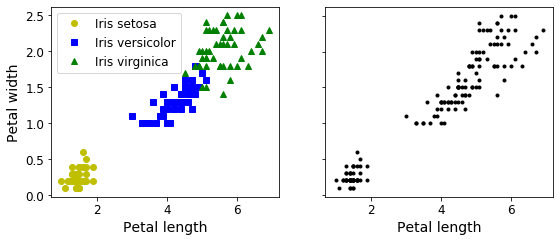

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

On the left image, the classes can be seeing with different markers. But not so on the right. But a clustering algorithm can reveal the same classes. Let us test that

A Gaussian Mixture Model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

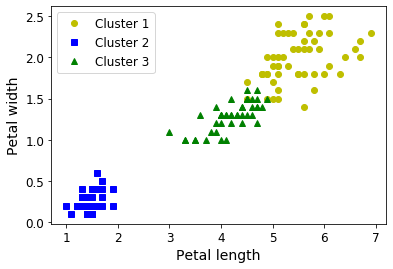

In [7]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

The similarity with the real classes above is remarkable!

# K-Means

The algorithm below demonstrates the K-Means technique for clustering

Let's start by generating some blobs:

In [8]:
from sklearn.datasets import make_blobs

In [9]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [10]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [11]:
def plot_clusters(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

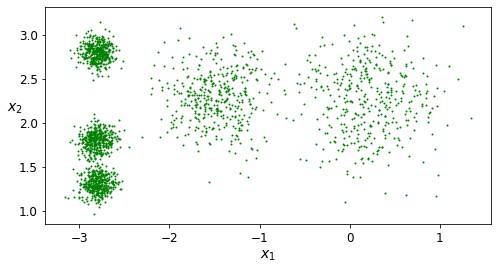

In [12]:
plt.figure(figsize=(8, 4))
plot_clusters(X, "green")
plt.show()

Nice! so we have our blobs

## Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [13]:
from sklearn.cluster import KMeans

In [14]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Note that you have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy. 
Each instance was assigned to one of the 5 clusters.
In the context of clustering, an instance’s label is the index of the cluster that this instance gets assigned to by the algorithm: this is not to be confused with the class labels in classification (remember that clustering is an unsupervised learning task). The KMeans instance preserves the labels of the instances it was trained on, available via the labels_ instance variable:

In [15]:
y_pred

array([4, 1, 0, ..., 3, 0, 1])

In [16]:
y_pred is kmeans.labels_

True

And the following 5 centroids (i.e., cluster centers) were estimated:

In [17]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

As noted above, KMeans instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the label of an instance is the index of the cluster that instance gets assigned to:

 Let us predict the labels of new instances:

In [18]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3])

## Decision Boundaries
Let's plot the model's decision boundaries. This gives us a Voronoi diagram:

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

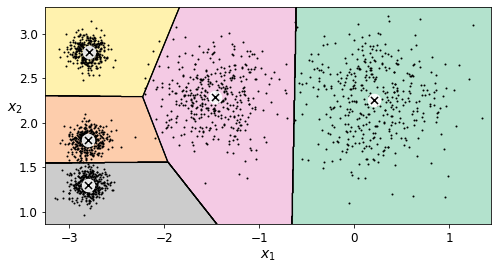

In [20]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.
 Indeed, the K-Means algorithm does not behave very well when the blobs have very different diameters because all it cares about when assigning an instance to a cluster is the distance to the centroid.

### Hard Clustering vs Soft Clustering

Instead of assigning each instance to a single cluster, i.e. hard clustering, it can be useful to give each instance a score per cluster, i.e. soft clustering. 
The score can be the distance between the instance and the centroid; conversely, it can be a similarity score (or affinity), such as the Gaussian Radial Basis Function. 
In the KMeans class, the transform() method measures the distance from each instance to every centroid:

In [21]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

The first instance in X_new is located at a distance of 2.81 from the first centroid, 0.33 from the second centroid, 2.90 from the third centroid, 1.49 from the fourth centroid, and 2.89 from the fifth centroid. If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: this transformation can be a very efficient nonlinear dimensionality reduction technique.

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [22]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

## K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:

* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.


The KMeans class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set init="random", n_init=1and algorithm="full". These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [23]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

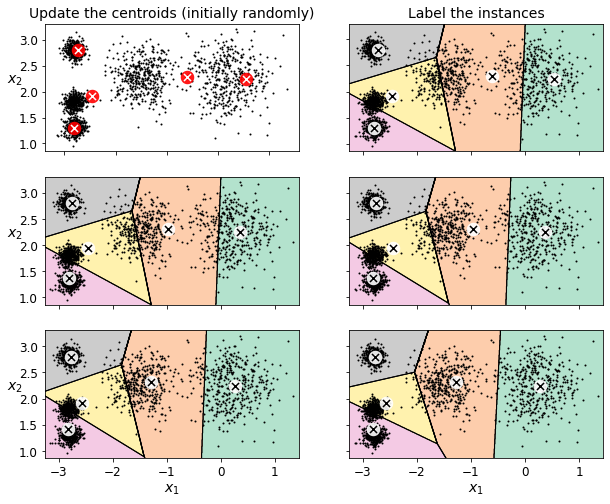

In [24]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)
plt.show()


Here is what happened:
the centroids are initialized randomly (top left), then the instances are labeled (top right), then the centroids are updated (center left), the instances are relabeled (center right), and so on. As you can see, in just three iterations, the algorithm has reached a clustering that seems close to optimal.



## K-Means Variability

Note that:
Although the algorithm is guaranteed to converge, it may not converge to the right solution (i.e., it may converge to a local optimum): whether it does or not depends on the centroid initialization.

For instance, in the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [25]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

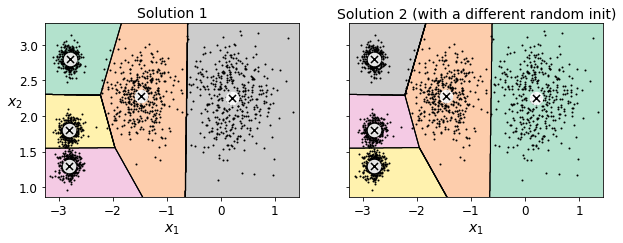

In [26]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

Let’s look at a few ways you can mitigate this risk by improving the centroid initialization.

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the inertia metric:

In [27]:
kmeans.inertia_

211.5985372581684

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [28]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

The score() method returns the negative inertia. Why negative? Well, it is because a predictor's score() method must always respect the "great is better" rule.

In [29]:
kmeans.score(X)

-211.59853725816856

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [30]:
kmeans_rnd_init1.inertia_

211.59853725816822

In [31]:
kmeans_rnd_init2.inertia_

211.59853725816822

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the n_init hyperparameter, Scikit-Learn runs the original algorithm n_init times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets n_init=10.

In [32]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

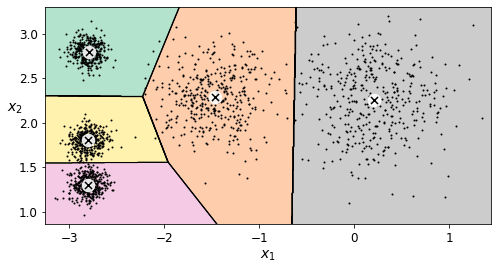

In [33]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()


### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a 2006 paper by David Arthur and Sergei Vassilvitskii:

Take one centroid $c_1$, chosen uniformly at random from the dataset.
Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
Repeat the previous step until all $k$ centroids have been chosen.
The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce n_init considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set init="k-means++" (this is actually the default):

In [34]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [35]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### Mini-Batch K-Means
Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches 

In [36]:
from sklearn.cluster import MiniBatchKMeans

In [37]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [38]:
minibatch_kmeans.inertia_

211.93186531476775

If the dataset does not fit in memory, the simplest option is to use the memmap class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

In [39]:
import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a memmap:

In [41]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [42]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

If your data is so large that you cannot use memmap, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [43]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [44]:
np.random.seed(42)

In [45]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [46]:
best_kmeans.score(X)

-211.70999744411483

Mini-batch K-Means is much faster than regular K-Means:

In [47]:
%timeit KMeans(n_clusters=5).fit(X)

50.5 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

29.8 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's much faster! However, its performance is often lower (higher inertia), and it keeps degrading as k increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [49]:
from timeit import timeit

In [50]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

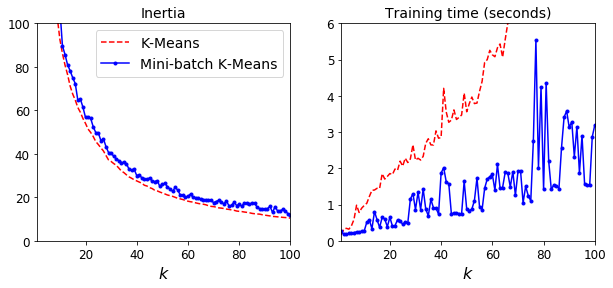

In [51]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()


The plot on the left compares the inertias of Mini-batch K-Means and regular K-Means models trained on the previous dataset using various numbers of clusters k. The difference between the two curves remains fairly constant, but this difference becomes more and more significant as k increases, since the inertia becomes smaller and smaller. In the plot on the right, you can see that Mini-batch K-Means is much faster than regular K-Means, and this difference increases with k.

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

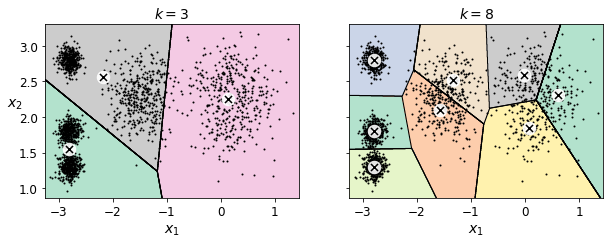

In [52]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [53]:
kmeans_k3.inertia_

653.2167190021553

In [54]:
kmeans_k8.inertia_

118.41983763508077

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [55]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

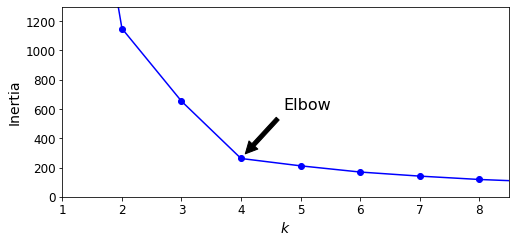

In [56]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

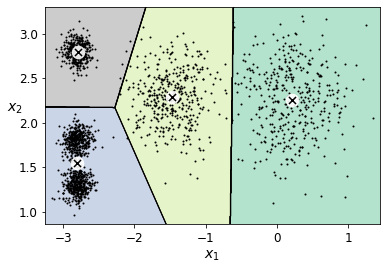

In [57]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()


Another approach is to look at the silhouette score, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and $b$ is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [58]:
from sklearn.metrics import silhouette_score

In [59]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [60]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

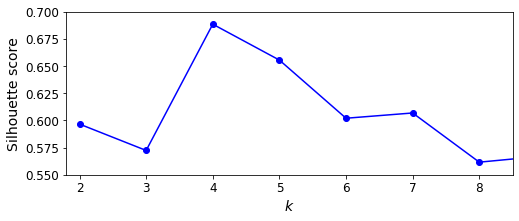

In [61]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a silhouette diagram:

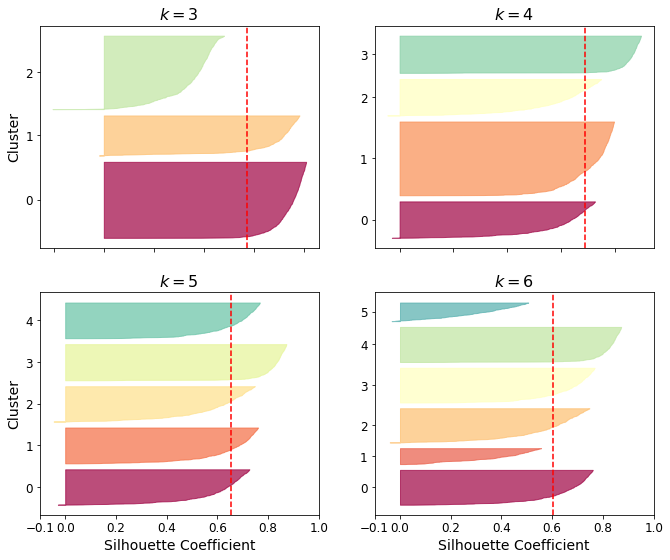

In [62]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### Limits of K-Means

K-Means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid suboptimal solutions, plus you need to specify the number of clusters, which can be quite a hassle. Moreover, K-Means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes. For example, the figures below show how K-Means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities, and orientations.

In [63]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

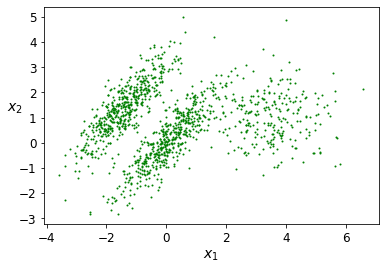

In [65]:
plot_clusters(X, "green")

In [66]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

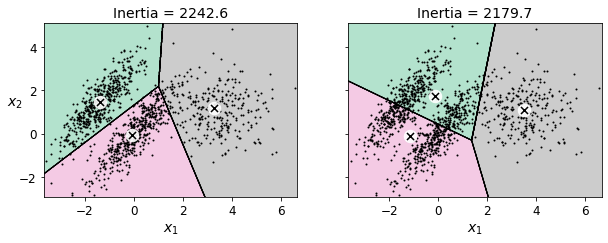

In [67]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

### Using clustering for Preprocessing

Clustering can be an efficient preprocessing step before a supervised learning algorithm.

Let's tackle the digits dataset which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [68]:
from sklearn.datasets import load_digits

In [69]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [70]:
from sklearn.model_selection import train_test_split

In [72]:
#from sklearn.linear_model import LogisticRegression
#log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
#log_reg.fit(X_train, y_train)

In [73]:
#log_reg.score(X_test, y_test)

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [74]:
from sklearn.pipeline import Pipeline

In [75]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
pipeline.score(X_test, y_test)

In [ ]:
1 - (1 - 0.977777) / (1 - 0.968888)

How about that? We reduced the error rate by over 28%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kmeans__n_clusters=2, total=  29.7s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.7s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=  36.5s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=  27.9s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total= 1.0min
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=  53.3s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=  49.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total= 1.1min
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total= 1.1min
[CV] kmeans__n_clusters=4 ............................................
[CV] .

KeyboardInterrupt: 

Let's see what the best number of clusters is:

In [78]:
grid_clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
grid_clf.score(X_test, y_test)

### Clustering for Semi-supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [82]:
n_labeled = 50

In [83]:
#log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
#log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
#log_reg.score(X_test, y_test)

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [84]:
k = 50

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

In [ ]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [ ]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [ ]:
#log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
#log_reg.fit(X_representative_digits, y_representative_digits)
#log_reg.score(X_test, y_test)

We jumped from 83.3% accuracy to 92.2%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

In [ ]:
log_reg.score(X_test, y_test)

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 20th percentile closest to the centroid:

In [ ]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [ ]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

In [ ]:
log_reg.score(X_test, y_test)

Nice! With just 50 labeled instances (just 5 examples per class on average!), we got 94% performance, which is pretty close to the performance of logistic regression on the fully labeled digits dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is very close to 99%:

In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

You could now do a few iterations of active learning:

Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
Train a new model with these additional labels.

## Gaussian Mixtures

This is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoidal shape, size, density, and orientation.

When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

There are several GMM variants. In the simplest variant, implemented in the GaussianMixture class, you must know in advance the number k of Gaussian distributions.

Let's work on this algorithm

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [ ]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

Let's look at the parameters that the EM algorithm estimated:

In [ ]:
gm.weights_

In [ ]:
gm.means_

In [ ]:
gm.covariances_

Did the algorithm actually converge?

Yes, good. How many iterations did it take?

In [ ]:
gm.n_iter_

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use predict() method or the predict_proba() method:

In [ ]:
gm.predict(X)

In [ ]:
gm.predict_proba(X)

This is a generative model, so you can sample new instances from it (and get their labels):

In [ ]:
X_new, y_new = gm.sample(6)
X_new

In [ ]:
y_new

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the probability density function (PDF) at any location using the score_samples() method:

In [ ]:
gm.score_samples(X)

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [ ]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [ ]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the covariance_type hyperparameter:

"full" (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
"tied": all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
"spherical": all clusters must be spherical, but they can have different diameters (i.e., different variances).
"diag": clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [ ]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

In [ ]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

In [ ]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

In [ ]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection (outlier detection): instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

Note:
Gaussian mixture models try to fit all the data, including the outliers, so if you have too many of them, this will bias the model’s view of “normality,” and some outliers may wrongly be considered as normal. If this happens, you can try to fit the model once, use it to detect and remove the most extreme outliers, then fit the model again on the cleaned-up dataset. Another approach is to use robust covariance estimation methods (see the EllipticEnvelope class).

In [ ]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

## Model selection

With K-Means, you could use the inertia or the silhouette score to select the appropriate number of clusters. But with Gaussian mixtures, it is not possible to use these metrics because they are not reliable when the clusters are not spherical or have different sizes. 

Instead, you can try to find the model that minimizes a theoretical information criterion, such:
* Bayesian information criterion (BIC) or:
* the Akaike information criterion (AIC)

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [ ]:
gm.bic(X)

In [ ]:
gm.aic(X)

We could compute the BIC manually like this:

In [ ]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [ ]:
bic, aic

In [ ]:
n_params

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. 

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [ ]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Let's search for best combination of values for both the number of clusters and the covariance_type hyperparameter:

Let's search for best combination of values for both the number of clusters and the covariance_type hyperparameter:

In [ ]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [ ]:
best_k

In [ ]:
best_covariance_type

## Variational Bayesian Gaussian Mixtures

Rather than manually searching for the optimal number of clusters, it is possible to use instead the BayesianGaussianMixture class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

In [ ]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

The algorithm automatically detected that only 3 components are needed.

In this model, the cluster parameters (including the weights, means, and covariance matrices) are not treated as fixed model parameters anymore, but as latent random variables, like the cluster assignments.

In [ ]:
np.round(bgm.weights_, 2)

In [ ]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [ ]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])